# Problem Identification and Modeling

### Task 1: Enrolment Gaps Detection

### Install xgboost

In [ ]:
%pip install xgboost

### Install prophet

In [ ]:
%pip install prophet

### Import the libraries

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from prophet import Prophet
import plotly.graph_objects as go

### Loading the dataset

In [2]:
df = pd.read_parquet('final_data/final_modeling_data.parquet')
df.head()

,date,state,district,Enrolment_Count,Demo_Update_Count,Bio_Update_Count,Enrol_MA_7,Demo_MA_7,Enrol_MA_30,Enrol_Lag_7,Enrol_Velocity,Update_to_Enrol_Ratio,Is_High_Maintenance,District_Cluster,Day_OfWeek,Month,Is_Weekend,Is_Quarter_End
0,2025-03-01,Andaman And Nicobar Islands,Andamans,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1,0,5,3,1,0
1,2025-04-01,Andaman And Nicobar Islands,Andamans,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1,0,1,4,0,0
2,2025-05-01,Andaman And Nicobar Islands,Andamans,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1,0,3,5,0,0
3,2025-06-01,Andaman And Nicobar Islands,Andamans,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1,0,6,6,1,0
4,2025-07-01,Andaman And Nicobar Islands,Andamans,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000000.0,1,0,1,7,0,0


### Get the district features

In [3]:
# We analyze at the DISTRICT level (aggregating over time for this specific model)
# We want to find districts that are anomalies *overall*
district_features = df.groupby(['state', 'district']).agg({
    'Enrolment_Count': 'sum',
    'Enrol_Velocity': 'mean',          # Average growth rate
    'Update_to_Enrol_Ratio': 'mean',   # Average maturity
    'Is_High_Maintenance': 'mean'      # % of days spent on maintenance
}).reset_index()

### Using Unsupervised learning - Isolation Forest

In [4]:
# 1. Select Features for Anomaly Detection
features = ['Enrolment_Count', 'Enrol_Velocity', 'Update_to_Enrol_Ratio']

# 2. Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(district_features[features])

# 3. Train Isolation Forest
# contamination=0.05 means we expect ~5% of districts to be anomalies (underserved/odd)
model = IsolationForest(contamination=0.05, random_state=42)
district_features['Anomaly'] = model.fit_predict(X)

# Isolation Forest returns -1 for Anomalies and 1 for Normal
# Mapping them: "Anomaly" (-1) -> True, "Normal" (1) -> False
district_features['Is_Anomaly'] = district_features['Anomaly'] == -1

# 4. Filter Results
anomalies = district_features[district_features['Is_Anomaly'] == True]

print(f"Detected {len(anomalies)} anomalous districts out of {len(district_features)}.")
print("Top 5 Anomalies (Potential Enrolment Gaps or Outliers):")
print(anomalies.sort_values('Enrolment_Count').head(5))

Detected 52 anomalous districts out of 1031.
Top 5 Anomalies (Potential Enrolment Gaps or Outliers):
             state      district  Enrolment_Count  Enrol_Velocity  \
651         Odisha  Kendrapara *              1.0       -0.953947   
585      Meghalaya        Kamrup              1.0       10.000000   
918  Uttar Pradesh   Kushi Nagar              1.0       -0.957055   
780     Tamil Nadu  Namakkal   *              1.0       -0.959538   
983    West Bengal       Burdwan              1.0        1.760000   

     Update_to_Enrol_Ratio  Is_High_Maintenance  Anomaly  Is_Anomaly  
651                    0.0                  0.0       -1        True  
585                    0.0                  0.0       -1        True  
918                    0.0                  0.0       -1        True  
780                    0.0                  0.0       -1        True  
983               800000.0                  0.8       -1        True  


### Visualize the Gaps

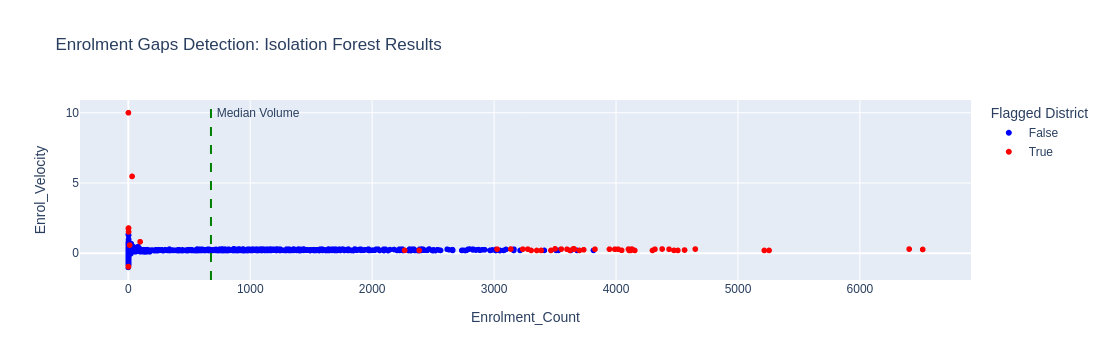

In [5]:
fig = px.scatter(
    district_features, 
    x="Enrolment_Count", 
    y="Enrol_Velocity", 
    color="Is_Anomaly",
    hover_name="district",
    hover_data=["state", "Update_to_Enrol_Ratio"],
    title="Enrolment Gaps Detection: Isolation Forest Results",
    labels={"Is_Anomaly": "Flagged District"},
    color_discrete_map={False: "blue", True: "red"} # Red = Anomalies
)

# Add threshold line for context (e.g., median enrolment)
median_enrol = district_features['Enrolment_Count'].median()
fig.add_vline(x=median_enrol, line_dash="dash", line_color="green", annotation_text="Median Volume")

fig.show()

### Task 2: Update Compliance Prediction

### Define the target

In [6]:
threshold = df['Bio_Update_Count'].quantile(0.25)
df['Is_Low_Compliance'] = (df['Bio_Update_Count'] <= threshold).astype(int)

### Select the Features

In [7]:
# 3. SELECT FEATURES
features = [
    'Enrolment_Count', 'Enrol_Velocity', 'Enrol_Lag_7',
    'Demo_MA_7', 'Update_to_Enrol_Ratio',
    'District_Cluster',
    'Is_Weekend', 'Is_Quarter_End'
]

# Drop rows with NaNs
model_df = df[features + ['Is_Low_Compliance']].dropna()

X = model_df[features]
y = model_df['Is_Low_Compliance']

### Train XGB Model

In [8]:
# 1. SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. TRAIN XGBOOST
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# 3. EVALUATE
y_pred = xgb_model.predict(X_test)

print("--- XGBoost Performance Report ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))

--- XGBoost Performance Report ---
Accuracy: 95.82%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     13791
           1       0.93      0.92      0.92      5179

    accuracy                           0.96     18970
   macro avg       0.95      0.94      0.95     18970
weighted avg       0.96      0.96      0.96     18970



### Feature Importance

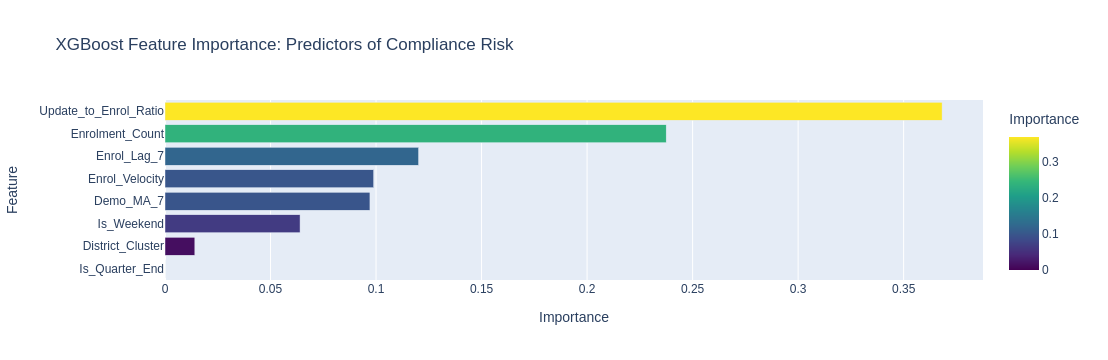

In [9]:
# 1. Get Feature Importances
importances = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

# 2. Plot
fig = px.bar(
    importances,
    x='Importance',
    y='Feature',
    orientation='h',
    title='XGBoost Feature Importance: Predictors of Compliance Risk',
    color='Importance',
    color_continuous_scale='Viridis'
)

fig.show()

### Task 3: Demand Forecasting

### Aggregating the data

In [15]:
# 2. AGGREGATE TO NATIONAL LEVEL
# Forecasting 700+ districts individually is too heavy for a demo.
daily_enrol = df.groupby('date')['Enrolment_Count'].sum().reset_index()
daily_update = df.groupby('date')[['Demo_Update_Count', 'Bio_Update_Count']].sum().sum(axis=1).reset_index(name='Total_Updates')
daily_update['date'] = daily_enrol['date'] # Sync dates

# 3. FORMAT FOR PROPHET ('ds' and 'y')
prophet_df = daily_enrol.rename(columns={'date': 'ds', 'Enrolment_Count': 'y'})

print(prophet_df.tail())

            ds        y
110 2025-12-26  13238.0
111 2025-12-27  11098.0
112 2025-12-28  11543.0
113 2025-12-29  14115.0
114 2025-12-31  16567.0


### Train Model and make future dataframe

In [16]:
# 1. INITIALIZE & TRAIN
# yearly_seasonality=True helps if you have >1 year of data
# weekly_seasonality=True captures the Monday-Friday vs Weekend pattern
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add Country Holidays
model.add_country_holidays(country_name='IN')

model.fit(prophet_df)

# 2. MAKE FUTURE DATAFRAME (30 Days Prediction)
future = model.make_future_dataframe(periods=30)

# 3. PREDICT
forecast = model.predict(future)

# Check the output
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

/home/nillohitroy/miniconda3/envs/venv/lib/python3.12/site-packages/holidays/countries/india.py:190: Warning:

Requested Holidays are available only from 2001 to 2035.

23:52:58 - cmdstanpy - INFO - Chain [1] start processing
23:52:58 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
140 2026-01-26  17389.690664  12238.830359  22272.957236
141 2026-01-27  15614.714648  10626.034455  20944.706144
142 2026-01-28  16564.263089  11446.233498  21785.570504
143 2026-01-29  16121.856731  10764.771822  21199.090473
144 2026-01-30  16814.123393  11465.074431  21678.517043


### Visualize the forecast

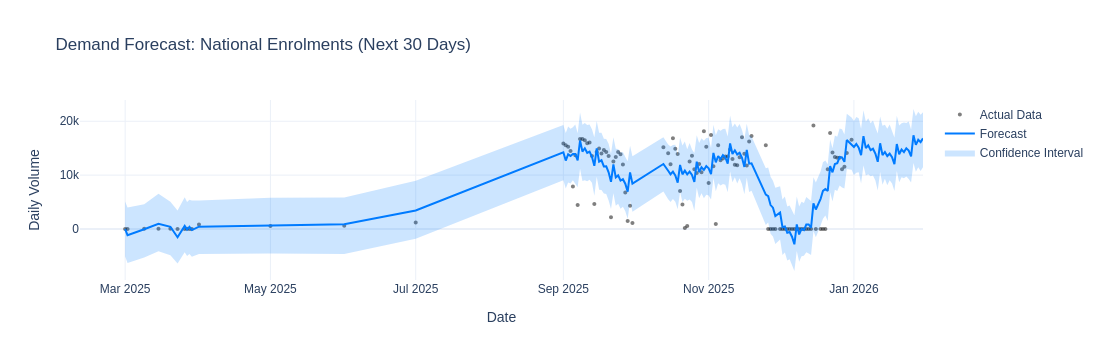

In [18]:
def plot_forecast_interactive(model, forecast, actual_df, title):
    fig = go.Figure()

    # 1. Plot Actual Historical Data
    fig.add_trace(go.Scatter(
        x=actual_df['ds'], y=actual_df['y'],
        mode='markers', name='Actual Data',
        marker=dict(color='black', size=4, opacity=0.5)
    ))

    # 2. Plot The Forecast Line
    fig.add_trace(go.Scatter(
        x=forecast['ds'], y=forecast['yhat'],
        mode='lines', name='Forecast',
        line=dict(color='#007bff', width=2)
    ))

    # 3. Plot Confidence Interval
    fig.add_trace(go.Scatter(
        x=pd.concat([forecast['ds'], forecast['ds'][::-1]]),
        y=pd.concat([forecast['yhat_upper'], forecast['yhat_lower'][::-1]]),
        fill='toself',
        fillcolor='rgba(0,123,255,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        name='Confidence Interval'
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Daily Volume",
        template="plotly_white"
    )
    fig.show()

plot_forecast_interactive(model, forecast, prophet_df, "Demand Forecast: National Enrolments (Next 30 Days)")

### Analyze the Components

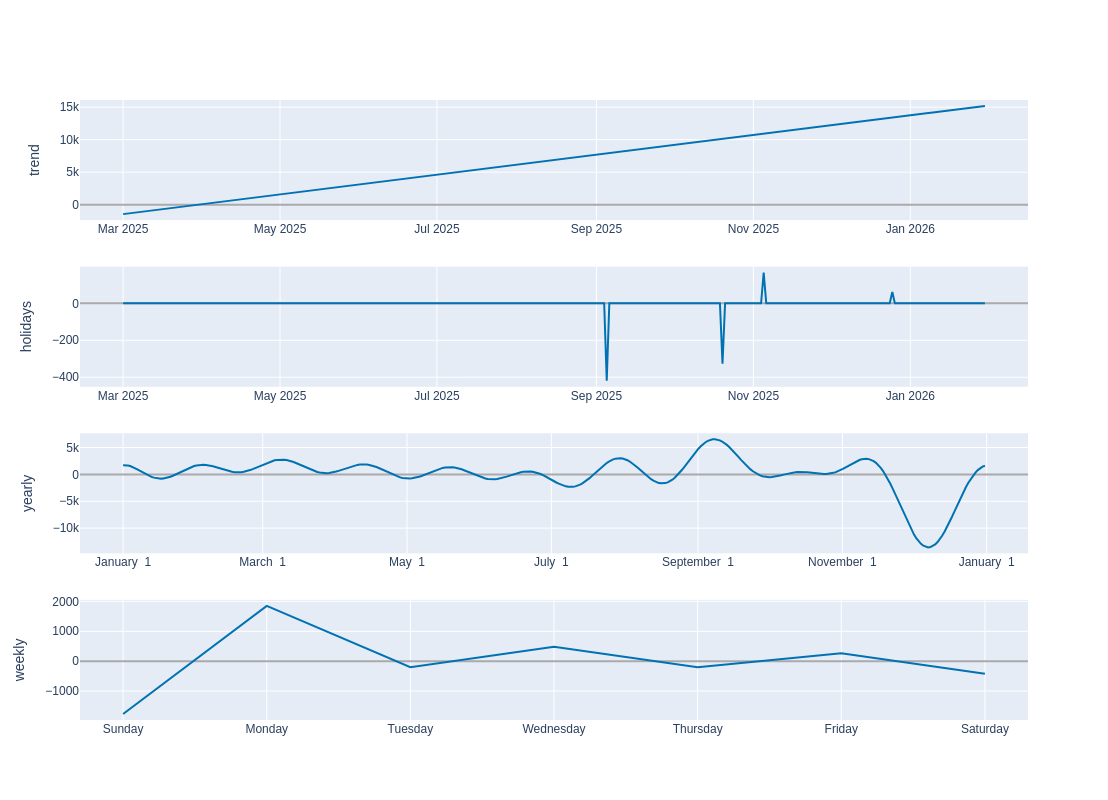

In [19]:
from prophet.plot import plot_components_plotly

# This generates a dashboard of:
# 1. Overall Trend
# 2. Weekly Seasonality
# 3. Yearly Seasonality
fig2 = plot_components_plotly(model, forecast)
fig2.show()